# Data-driven modeling - Tutorial 2 - Nonlinear material model

Lecturer: Dr.-Ing. Mauricio Fernández

## Contents of this tutorial

* [1. Nonlinear material model](#1.-Nonlinear-material-model)
* [2. Solution](#2.-Solution)
    * [2.1 Data](#2.1-Data)
    * [2.2 Examine data](#2.2-Examine-data)
    * [2.3 Model](#2.3-Model)
    * [2.4 Train](#2.4-Train)
    * [2.5 Evaluate](#2.5-Evaluate)

## 1. Nonlinear material model

For given strain-stress data, calibrate an ANN as a surrogate model.

## Exercise

Train an ANN with given strain-stress data:

* Load the data file 'data.h5' from [Fritzen, Fernández and Larsson (2019)](https://www.frontiersin.org/articles/10.3389/fmats.2019.00075/full) (available at subfolder of this tutorial `files/data`). Use the subset 'training' of the data.
* Plot the first four deformation paths
* Build a tf.keras model. Use the SOFTPLUTS activation function
* Train the model for 100 epochs
* Plot the data and trained model for the first four deformations paths

## 2. Solution

In [1]:
import numpy as np
import h5py as h5
import tensorflow as tf
import matplotlib.pyplot as plt

### 2.1 Data

Open hdf5 file and print group keys

In [2]:
data = h5.File('files/data/data.h5', 'r')

print('\nKeys in data at fisrt level:')
print(data.keys())

print('\nKeys in data > training:')
print(data['training'].keys())


Keys in data at fisrt level:
<KeysViewHDF5 ['Monte Carlo', 'training', 'validation']>

Keys in data > training:
<KeysViewHDF5 ['strain', 'stress_FE', 'stress_ROM16', 'stress_ROM24', 'stress_ROM32', 'stress_ROM48', 'stress_ROM64', 'stress_ROM80', 'stress_ROM96', 'tangent_ROM96']>


Get data: 
* remember convention $(\varepsilon_{11},\varepsilon_{22},\varepsilon_{33},\sqrt{2} \varepsilon_{12},\sqrt{2} \varepsilon_{13},\sqrt{2} \varepsilon_{23})$

In [3]:
xs = data['training']['strain']
fs = data['training']['stress_FE']

print('\nShapes of input and output:')
print(xs.shape)
print(fs.shape)

print(xs[0:4])


Shapes of input and output:
(10368, 6)
(10368, 6)
[[-7.43789818e-05 -3.88406733e-05  1.19396136e-04 -1.16749375e-04
   3.39936380e-05  4.62182385e-04]
 [-2.97515927e-04 -1.55362693e-04  4.77584543e-04 -4.66997502e-04
   1.35974552e-04  1.84872954e-03]
 [-5.20652872e-04 -2.71884713e-04  8.35772950e-04 -8.17245628e-04
   2.37955466e-04  3.23527669e-03]
 [-7.43789818e-04 -3.88406733e-04  1.19396136e-03 -1.16749375e-03
   3.39936380e-04  4.62182385e-03]]


### 2.2 Examine data

[0.00049969 0.00199878 0.00349786 0.00499695 0.00749542 0.00999389
 0.01499084 0.02498474 0.03997558 0.00048147 0.00192588 0.0033703
 0.00481471 0.00722207 0.00962942 0.01444414 0.02407356 0.0385177
 0.00049569 0.00198277 0.00346984 0.00495692 0.00743538 0.00991384
 0.01487076 0.0247846  0.03965536 0.00040445 0.00161778 0.00283112]


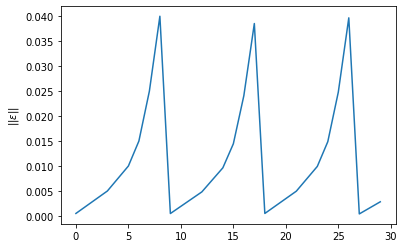

In [4]:
xs2 = np.linalg.norm(xs, axis=1)[:30]
print(xs2)
plt.figure()
plt.plot(xs2)
plt.ylabel('$||\\varepsilon||$')
plt.show()

Standardize colors for dirst 4 deformation paths

In [5]:
colors = ['blue', 'orange', 'green', 'red']

Plot first 4 deformation paths (each deformation path has 9 data points)

Plot strain norm vs. stress norm

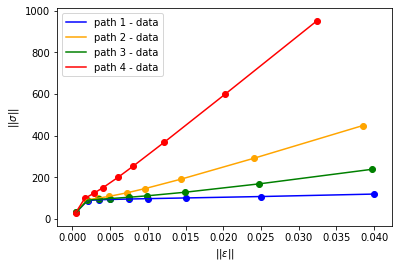

In [6]:
plt.figure()
for i in range(4):
    xs2 = np.linalg.norm(xs[9*i:9*(i+1)], axis=1)    
    fs2 = np.linalg.norm(fs[9*i:9*(i+1)], axis=1)
    plt.plot(xs2, fs2, color=colors[i], label='path %i - data' % (i+1))
    plt.scatter(xs2, fs2, color=colors[i])
plt.xlabel('$||\\varepsilon||$')
plt.ylabel('$||\\sigma||$')
plt.legend()
plt.show()

Function to compute von Mises stress $\sigma_{vM}$ for a list of stresses

In [7]:
def stress_vM(stresses):
    stresses_iso = np.sum(stresses[:,:3], axis=1).reshape([-1,1])*1/3*np.array([1,1,1,0,0,0])
    stresses_dev = stresses - stresses_iso
    return np.linalg.norm(stresses_dev, axis=1)

Plot strain norm vs. von Mises stress

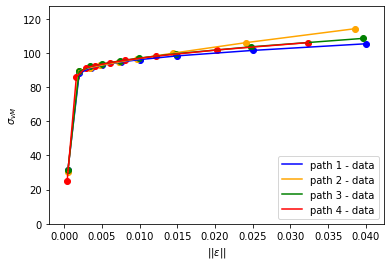

In [8]:
plt.figure()
for i in range(4):
    xs2 = np.linalg.norm(xs[9*i:9*(i+1)], axis=1)
    fs2 = stress_vM(fs[9*i:9*(i+1)])
    plt.plot(xs2, fs2, color=colors[i], label='path %i - data' % (i+1))
    plt.scatter(xs2, fs2, color=colors[i])
plt.xlabel('$||\\varepsilon||$')
plt.ylabel('$\\sigma_{vM}$')
plt.ylim(0,max(fs2)*1.2)
plt.legend()
plt.show()

Save first 4 paths for later evaluation

In [9]:
xs_ev = xs[:9*4]
fs_ev = fs[:9*4]

Transform input for better usage of activation functions

In [11]:
print(np.mean(xs, axis=0))
print(np.std(xs, axis=0))

[-1.39682211e-04  6.21148417e-05  8.12561373e-05 -3.48467020e-04
  6.05625692e-05  1.56899687e-04]
[0.00577254 0.00577391 0.00577367 0.00699377 0.00700179 0.00700054]


In [12]:
mu = np.mean(xs, axis=0)
sig = np.std(xs, axis=0)

print(mu.shape)
print(sig.shape)

xs = (xs-mu)/sig

print(xs.shape)

(6,)
(6,)
(10368, 6)


In [13]:
print(np.mean(xs, axis=0))
print(np.std(xs, axis=0))

[-3.88492393e-17 -5.55539839e-17  1.85037171e-17 -7.62742921e-17
  2.24218363e-16 -6.60993893e-16]
[1. 1. 1. 1. 1. 1.]


Transform to tf objects (tensors)

In [14]:
xs = tf.constant(xs, dtype=tf.float32)
fs = tf.constant(fs, dtype=tf.float32)

### 2.3 Model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, 'softplus', input_shape=[6])
    ,tf.keras.layers.Dense(8, 'softplus')
    ,tf.keras.layers.Dense(6)
    ])

model.summary()

model.compile('adam', 'mse')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 54        
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________


Check MSE (loss)

In [16]:
model.evaluate(xs, fs)

10368/10368 [==============================] - 1s 75us/sample - loss: 14119.0740


14119.07401756004

### 2.4 Train

In [17]:
model.fit(xs, fs, epochs=100, verbose=2)

Train on 10368 samples
Epoch 1/100
10368/10368 - 1s - loss: 14103.4732
Epoch 2/100
10368/10368 - 0s - loss: 14044.3377
Epoch 3/100
10368/10368 - 0s - loss: 13899.0655
Epoch 4/100
10368/10368 - 0s - loss: 13592.6842
Epoch 5/100
10368/10368 - 0s - loss: 13037.5773
Epoch 6/100
10368/10368 - 0s - loss: 12020.9494
Epoch 7/100
10368/10368 - 0s - loss: 10217.3857
Epoch 8/100
10368/10368 - 0s - loss: 7632.0031
Epoch 9/100
10368/10368 - 0s - loss: 4924.7460
Epoch 10/100
10368/10368 - 0s - loss: 2926.6535
Epoch 11/100
10368/10368 - 0s - loss: 1901.6669
Epoch 12/100
10368/10368 - 0s - loss: 1501.3586
Epoch 13/100
10368/10368 - 0s - loss: 1334.2038
Epoch 14/100
10368/10368 - 0s - loss: 1237.8437
Epoch 15/100
10368/10368 - 0s - loss: 1169.7590
Epoch 16/100
10368/10368 - 0s - loss: 1118.8811
Epoch 17/100
10368/10368 - 0s - loss: 1077.2860
Epoch 18/100
10368/10368 - 0s - loss: 1042.9541
Epoch 19/100
10368/10368 - 0s - loss: 1014.8106
Epoch 20/100
10368/10368 - 0s - loss: 992.6831
Epoch 21/100
10368/1

### 2.5 Evaluate

In [18]:
model.evaluate(xs, fs)

10368/10368 [==============================] - 0s 36us/sample - loss: 529.6434


529.6434171700183

Evaluate first 4 paths with originial data

In [19]:
xs_ev2 = xs_ev
xs_ev2 = (xs_ev2 - mu)/sig

fs_ev_model = model.predict(xs_ev2)

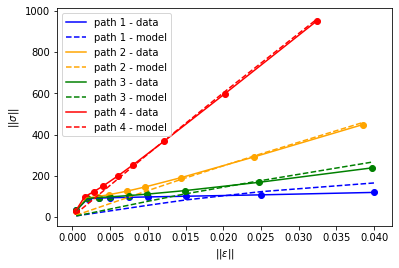

In [20]:
plt.figure()
for i in range(4):
    xs2 = np.linalg.norm(xs_ev[9*i:9*(i+1)], axis=1)    
    fs2 = np.linalg.norm(fs_ev[9*i:9*(i+1)], axis=1)
    fs22 = np.linalg.norm(fs_ev_model[9*i:9*(i+1)], axis=1)
    plt.plot(xs2, fs2, label='path %i - data' % (i+1), color=colors[i])
    plt.scatter(xs2, fs2, color=colors[i])
    plt.plot(xs2, fs22, label='path %i - model' % (i+1), color=colors[i], linestyle='--')
plt.xlabel('$||\\varepsilon||$')
plt.ylabel('$||\\sigma||$')
plt.legend()
plt.show()

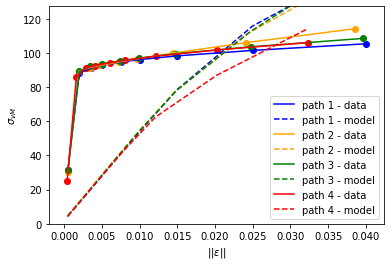

In [21]:
plt.figure()
for i in range(4):
    xs2 = np.linalg.norm(xs_ev[9*i:9*(i+1)], axis=1)
    fs2 = stress_vM(fs_ev[9*i:9*(i+1)])
    fs22 = stress_vM(fs_ev_model[9*i:9*(i+1)])
    plt.plot(xs2, fs2, label='path %i - data' % (i+1), color=colors[i])
    plt.scatter(xs2, fs2, color=colors[i])
    plt.plot(xs2, fs22, label='path %i - model' % (i+1), color=colors[i], linestyle='--')
plt.xlabel('$||\\varepsilon||$')
plt.ylabel('$\\sigma_{vM}$')
plt.ylim(0,max(fs2)*1.2)
plt.legend()
plt.show()

The calibrated model may seem ok with respect to the MSE for the stresses, but not when compared to the von Mises stress, which is crucial for many materials. Physical insight helps to improve the architecture of ANN. More advanced approaches are presented in [Fritzen, Fernández and Larsson (2019)](https://www.frontiersin.org/articles/10.3389/fmats.2019.00075/full)